
# Feature Reduction Study — Vélib’ Forecast (T+15 min)

**Purpose**: Identify a minimal, production-ready feature set preserving ≥ 98–99% of baseline performance while improving robustness and latency.

**Author**: Adrien — _Data Scientist_  
**Date**: 2025-10-01 09:06 UTC

---

## Executive summary (fill after running)
- **Baseline model**: …  
- **Reduced features**: … (count …)  
- **Perf delta** (MAE / WAPE / % within ±2 bikes): …  
- **Notes**: …



## 1. Objectives & Metrics

**Primary metrics**
- `MAE` (global + per-station median)
- `WAPE`
- `% within ±2 bikes`
- (Optional) `% within ±10% capacity`

**Constraints**
- Predictions clipped to `[0, capacity]`
- Temporal CV or holdout (no leakage)
- Station generalization (grouped splits by station)


In [1]:
# Imports
import os, sys, json, math
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)


In [2]:
# Metrics helpers
def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred)))

def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return float(np.nan)
    return float(np.sum(np.abs(y_true - y_pred)) / denom)

def pct_within_abs(y_true: np.ndarray, y_pred: np.ndarray, thr: float = 2.0) -> float:
    return float(np.mean(np.abs(y_true - y_pred) <= thr))

def pct_within_capacity_ratio(y_true: np.ndarray, y_pred: np.ndarray, capacity: np.ndarray, ratio: float = 0.10) -> float:
    thr = ratio * np.maximum(capacity, 1.0)
    return float(np.mean(np.abs(y_true - y_pred) <= thr))

def clip_to_capacity(y_pred: np.ndarray, capacity: np.ndarray) -> np.ndarray:
    return np.clip(y_pred, 0, np.maximum(capacity, 0))



## 2. Data Loading & Temporal Splits (Config)

Set paths/patterns below depending on your storage format.


In [3]:
# === 2. Data Loading & Temporal Splits (Config) ===
from pathlib import Path
import json
import pandas as pd
import numpy as np

# Timestamp column: mets 'tbin_utc' (bins 5 min) ou 'ts_utc'
TS_COL = 'tbin_utc'

# Colonnes requises minimales (avant création de y)
REQUIRE_COLUMNS = ['station_id', 'capacity', TS_COL]

# (Option) fichier unique Parquet
BASELINE_FEATURES_PARQUET = Path('/mnt/data/your_features.parquet')  # laisser si tu utilises les shards

# (Option) splits via JSON ; sinon on utilisera la valeur par défaut plus bas
SPLIT_DATES_JSON = Path('/mnt/data/splits.json')

assert True  # garde la cellule exécutable même sans fichiers


### 2.a Load Daily Shards — DuckDB

Use this if your daily shards are **DuckDB files** (e.g., `velib_db_daily_velib_*.duckdb`).  
The loader will auto-detect a user table if `TABLE_NAME` is not provided.


In [4]:
# === 2.a Load Daily Shards — DuckDB ===
from typing import Optional, List
from pathlib import Path

DUCKDB_GLOB = 'velib_db_daily_velib_*.duckdb'  # adapte à tes fichiers
TABLE_NAME: Optional[str] = None               # ou 'daily' si tu connais
DATE_FROM: Optional[str] = None                # '2025-09-25' (incl.)
DATE_TO:   Optional[str] = None                # '2025-10-01' (excl.)

def _duckdb_list_tables(conn) -> List[str]:
    q = """
    select table_schema, table_name
    from information_schema.tables
    where table_type = 'BASE TABLE'
    order by table_schema, table_name
    """
    df = conn.execute(q).df()
    out = []
    for _, r in df.iterrows():
        schema = str(r['table_schema']).lower()
        name = str(r['table_name'])
        if schema in {'information_schema', 'duckdb_temp'}:
            continue
        out.append(f'{schema}.{name}' if schema != 'main' else name)
    return out

def _build_sql(table: str, ts_col: str, start=None, end=None) -> str:
    where = []
    if start:
        where.append(f"{ts_col} >= TIMESTAMP '{start} 00:00:00+00'")
    if end:
        where.append(f"{ts_col} < TIMESTAMP '{end} 00:00:00+00'")
    where_sql = (" where " + " and ".join(where)) if where else ""
    return f"select * from {table}{where_sql}"

# Chargement
try:
    import duckdb  # type: ignore
    files = sorted(Path('.').glob(DUCKDB_GLOB))
    print(f"[DuckDB] Found {len(files)} shard(s) matching '{DUCKDB_GLOB}'.")
    duck_frames = []
    union_cols = set()

    # Pass 1: collect schema union
    for f in files:
        try:
            con = duckdb.connect(str(f), read_only=True)
            tables = [TABLE_NAME] if TABLE_NAME else _duckdb_list_tables(con)
            if not tables:
                con.close(); continue
            tbl = tables[0]
            cols = con.execute(f"select * from {tbl} limit 0").df().columns.tolist()
            union_cols.update(cols)
            con.close()
        except Exception as e:
            print(f"[warn] Could not introspect {f.name}: {e}")

    union_cols = list(union_cols)

    # Pass 2: load & align
    for f in files:
        try:
            con = duckdb.connect(str(f), read_only=True)
            tables = [TABLE_NAME] if TABLE_NAME else _duckdb_list_tables(con)
            if not tables:
                con.close(); continue
            tbl = tables[0]
            sql = _build_sql(tbl, TS_COL, DATE_FROM, DATE_TO)
            dfi = con.execute(sql).df()
            con.close()
            # align union cols
            miss = [c for c in union_cols if c not in dfi.columns]
            for c in miss:
                dfi[c] = pd.NA
            dfi = dfi[union_cols]
            if TS_COL in dfi.columns:
                dfi[TS_COL] = pd.to_datetime(dfi[TS_COL], utc=True, errors='coerce')
            duck_frames.append(dfi)
        except Exception as e:
            print(f"[warn] Failed to load {f.name}: {e}")

    if duck_frames:
        df = pd.concat(duck_frames, ignore_index=True)
        if TS_COL in df.columns:
            df = df.sort_values(TS_COL).reset_index(drop=True)
        print("[DuckDB] Loaded union:", df.shape)
except ModuleNotFoundError:
    print("[DuckDB] 'duckdb' not installed — skipping this loader.")

[DuckDB] Found 5 shard(s) matching 'velib_db_daily_velib_*.duckdb'.
[DuckDB] Loaded union: (1945908, 14)



### 2.b Load Daily Shards — Parquet

Use this if your shards are **Parquet files** in a directory.


In [5]:
# === 2.b Load Daily Shards — Parquet ===
PARQUET_DIR = Path('.')
PARQUET_GLOB = '*.parquet'
PARQ_DATE_FROM = None
PARQ_DATE_TO = None

def _apply_date_filter(df, ts_col: str, start=None, end=None):
    if ts_col not in df.columns:
        return df
    out = df
    if start:
        out = out[out[ts_col] >= pd.Timestamp(start, tz='UTC')]
    if end:
        out = out[out[ts_col] < pd.Timestamp(end, tz='UTC')]
    return out

if 'df' not in globals() or df.empty:
    files = sorted(PARQUET_DIR.glob(PARQUET_GLOB))
    print(f"[Parquet] Found {len(files)} shard(s) in {PARQUET_DIR} matching '{PARQUET_GLOB}'.")
    all_cols, dfs = set(), []
    for f in files:
        try:
            d0 = pd.read_parquet(f, engine='pyarrow').head(0)
            all_cols.update(d0.columns.tolist())
        except Exception as e:
            print(f"[warn] Could not read schema of {f.name}: {e}")
    all_cols = list(all_cols)

    for f in files:
        try:
            dfi = pd.read_parquet(f, engine='pyarrow')
            if TS_COL in dfi.columns:
                dfi[TS_COL] = pd.to_datetime(dfi[TS_COL], utc=True, errors='coerce')
            dfi = _apply_date_filter(dfi, TS_COL, PARQ_DATE_FROM, PARQ_DATE_TO)
            miss = [c for c in all_cols if c not in dfi.columns]
            for c in miss:
                dfi[c] = pd.NA
            dfi = dfi[all_cols]
            dfs.append(dfi)
        except Exception as e:
            print(f"[warn] Skipped {f.name}: {e}")

    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        if TS_COL in df.columns:
            df = df.sort_values(TS_COL).reset_index(drop=True)
        print("[Parquet] Loaded union:", df.shape)

# Fallback single table
if ('df' not in globals() or df.empty) and BASELINE_FEATURES_PARQUET.exists():
    df = pd.read_parquet(BASELINE_FEATURES_PARQUET)
    if TS_COL in df.columns:
        df[TS_COL] = pd.to_datetime(df[TS_COL], utc=True, errors='coerce')
    print("[Parquet] Loaded single table:", df.shape)



### 2.c Optional: Rename Columns / Schema Fix

Use this cell to normalize your schema (e.g., `stationcode` → `station_id`, `ts_utc` → `ts`).  
Edit `RENAME_MAP` as needed.


In [6]:
# === 2.c Schema Fix & Derived Columns (raw → study-ready) ===
STATION_COL = 'station_id'

# 1) Renames minimaux
RENAME_MAP = {
    'capacity': 'capacity_bin',   # aligne avec le reste du notebook
    # 'stationcode': 'station_id',  # décommente si nécessaire
    # 'ts_utc': 'tbin_utc',         # si tu préfères utiliser ts_utc comme TS_COL
}
if 'df' in globals() and not df.empty and RENAME_MAP:
    df = df.rename(columns=RENAME_MAP)

# 2) Construire 'bikes' si absent/NaN total
if ('bikes' not in df.columns) or df['bikes'].isna().all():
    if {'mechanical', 'ebike'}.issubset(df.columns):
        df['bikes'] = df['mechanical'].fillna(0) + df['ebike'].fillna(0)
    else:
        raise ValueError("Colonnes 'mechanical' et 'ebike' absentes: impossible de construire 'bikes'.")

# 3) Vérifs & tri
missing_req = [c for c in REQUIRE_COLUMNS if c not in df.columns]
if missing_req:
    print("[warn] Missing required before target creation:", missing_req)

df[TS_COL] = pd.to_datetime(df[TS_COL], utc=True, errors='coerce')
df = df.sort_values([STATION_COL, TS_COL]).reset_index(drop=True)

# 4) Ratio d'occupation courant
df['occ_ratio_bin'] = df['bikes'] / df['capacity_bin'].clip(lower=1)

[warn] Missing required before target creation: ['capacity']


In [7]:
# === 2.c bis Create target y (T+15 min) ===
H_MIN = 15
BIN_MIN = 5
SHIFT_BINS = H_MIN // BIN_MIN  # 3

# y = vélos observés à +15 min (lead par station)
df['y'] = df.groupby(STATION_COL)['bikes'].shift(-SHIFT_BINS)

# drop lignes sans cible (fin de séquence)
df = df.dropna(subset=['y']).reset_index(drop=True)

print("y describe:", df['y'].describe())
print("Coverage after y creation:", df.shape)

y describe: count    1.941453e+06
mean     7.412904e+00
std      9.214139e+00
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.100000e+01
max      6.800000e+01
Name: y, dtype: float64
Coverage after y creation: (1941453, 16)



### 2.d Sanity Checks
Checks for required columns, NaNs, and temporal coverage.


In [8]:
# === 2.d Sanity Checks ===
req_now = ['y', 'station_id', 'capacity_bin', TS_COL]
missing_now = [c for c in req_now if c not in df.columns] if 'df' in globals() else req_now
if 'df' in globals() and isinstance(df, pd.DataFrame) and not df.empty and not missing_now:
    print("[OK] All required columns present.")
    print("Shape:", df.shape)
    display(df.head())
    print("\nNaN counts (top 20):")
    display(df.isna().sum().sort_values(ascending=False).head(20))
    print("\nTime coverage:")
    print("min:", df[TS_COL].min(), "max:", df[TS_COL].max())
else:
    print("[ERROR] Missing required columns:", missing_now)

[OK] All required columns present.
Shape: (1941453, 16)


,bikes,ebike,status,ingest_latency_s,lon,station_id,ts_utc,lat,ingested_at,mechanical,source_etag,capacity_bin,ts_paris,tbin_utc,occ_ratio_bin,y
0,8,0,OK,NaN,2.334388,6245,2025-09-26 09:32:38,48.866811,NaT,8,None,27,NaT,2025-09-26 09:30:00+00:00,0.296296,8.0
1,8,0,OK,NaN,2.334388,6245,2025-09-26 09:32:38,48.866811,NaT,8,None,27,NaT,2025-09-26 09:30:00+00:00,0.296296,7.0
2,8,0,OK,NaN,2.334388,6245,2025-09-26 09:32:38,48.866811,NaT,8,None,27,NaT,2025-09-26 09:30:00+00:00,0.296296,7.0
3,8,0,OK,NaN,2.334388,6245,2025-09-26 09:32:38,48.866811,NaT,8,None,27,NaT,2025-09-26 09:30:00+00:00,0.296296,7.0
4,7,0,OK,NaN,2.334388,6245,2025-09-26 10:33:00,48.866811,NaT,7,None,27,NaT,2025-09-26 10:30:00+00:00,0.259259,7.0



NaN counts (top 20):


ingest_latency_s    1941453
ts_paris            1941453
source_etag         1941453
ingested_at         1941453
lon                       0
bikes                     0
ebike                     0
status                    0
lat                       0
ts_utc                    0
station_id                0
mechanical                0
capacity_bin              0
tbin_utc                  0
occ_ratio_bin             0
y                         0
dtype: int64


Time coverage:
min: 2021-02-21 19:05:00+00:00 max: 2025-09-30 22:45:00+00:00



### 2.e Define Temporal Splits


In [9]:
# === 2.e Define Temporal Splits ===
from typing import Tuple

def load_splits(path: Path | None) -> dict:
    if path and path.exists():
        return json.loads(path.read_text(encoding='utf-8'))
    # Couverture: 2025-09-25 → 2025-09-30
    return {
        "train": {"start": "2025-09-25", "end": "2025-09-29"},  # 25–28
        "valid": {"start": "2025-09-29", "end": "2025-09-30"},  # 29
        "test":  {"start": "2025-09-30", "end": "2025-10-01"}   # 30
    }

splits = load_splits(SPLIT_DATES_JSON)
splits

{'train': {'start': '2025-09-25', 'end': '2025-09-29'},
 'valid': {'start': '2025-09-29', 'end': '2025-09-30'},
 'test': {'start': '2025-09-30', 'end': '2025-10-01'}}

In [10]:
# === Helpers for splits ===
def filter_time_range(df: pd.DataFrame, start: str, end: str, ts_col: str = 'ts') -> pd.DataFrame:
    out = df.copy()
    out[ts_col] = pd.to_datetime(out[ts_col], utc=True, errors='coerce')
    return out[(out[ts_col] >= pd.Timestamp(start, tz='UTC')) & (out[ts_col] < pd.Timestamp(end, tz='UTC'))]

def make_splits(df: pd.DataFrame, ts_col: str = 'ts') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tr = filter_time_range(df, **splits["train"], ts_col=ts_col)
    va = filter_time_range(df, **splits["valid"], ts_col=ts_col)
    te = filter_time_range(df, **splits["test"],  ts_col=ts_col)
    return tr, va, te


## 3. Baseline (Full Feature Set)

Use your production model class and hyperparameters here.  
The notebook ships with a **placeholder** mean-per-station model to keep it runnable.


In [11]:
# --- A) Build time-series features from raw ---
assert 'bikes' in df.columns and 'capacity_bin' in df.columns, "bikes/capacity_bin requis"
df = df.sort_values(['station_id', TS_COL]).reset_index(drop=True)

# ratio courant si manquant
if 'occ_ratio_bin' not in df.columns:
    df['occ_ratio_bin'] = df['bikes'] / df['capacity_bin'].clip(lower=1)

def add_lags(df, col, ks):
    for k in ks:
        df[f"lag_{'nb' if col=='bikes' else 'occ'}_{k}b"] = df.groupby('station_id')[col].shift(k)
    return df

def add_roll_mean(df, col, w):
    ser = df.groupby('station_id')[col].apply(lambda s: s.shift(1).rolling(w, min_periods=max(1, w//3)).mean())
    ser.index = df.index
    df[f"roll_{'nb' if col=='bikes' else 'occ'}_{w}b"] = ser
    return df

def _slope(y):
    import numpy as np
    y = np.asarray(y, dtype=float)
    m = ~np.isnan(y)
    if m.sum() < len(y)//2: return np.nan
    x = np.arange(m.sum(), dtype=float)
    yy = y[m]
    vx = np.var(x)
    if vx == 0: return 0.0
    return float(np.cov(x, yy, bias=True)[0,1] / vx)

def add_trend(df, col, w):
    ser = df.groupby('station_id')[col].apply(
        lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).apply(_slope, raw=False)
    )
    ser.index = df.index
    df[f"trend_{'nb' if col=='bikes' else 'occ'}_{w}b"] = ser
    return df

# Lags (1,3,6,12,24,48), Rollings (12,24), Trends (12)
df = add_lags(df, 'bikes', [1,3,6,12,24,48])
df = add_lags(df, 'occ_ratio_bin', [1,3,6,12,24,48])
df = add_roll_mean(df, 'bikes', 12); df = add_roll_mean(df, 'bikes', 24)
df = add_roll_mean(df, 'occ_ratio_bin', 12); df = add_roll_mean(df, 'occ_ratio_bin', 24)
df = add_trend(df, 'bikes', 12); df = add_trend(df, 'occ_ratio_bin', 12)

In [12]:
# --- B) Calendar features from TS_COL ---
ts = pd.to_datetime(df[TS_COL], utc=True, errors='coerce')
df['hour'] = ts.dt.hour.astype('int16')
df['dow'] = ts.dt.dayofweek.astype('int8')          # 0=lundi … 6=dimanche
df['is_weekend'] = (df['dow'] >= 5).astype('int8')

# Encodages cycliques heure/minute
minute_of_day = ts.dt.hour * 60 + ts.dt.minute
df['tod_sin'] = np.sin(2*np.pi*minute_of_day/1440).astype('float32')
df['tod_cos'] = np.cos(2*np.pi*minute_of_day/1440).astype('float32')
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24).astype('float32')
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24).astype('float32')

# (Optionnel, si tu as la lib 'holidays' FR installée)
# import holidays
# fr_holidays = holidays.France()
# df['is_holiday_fr'] = ts.dt.date.map(lambda d: d in fr_holidays).astype('int8')

In [13]:
# === 3.1 (fix) — build numeric-only BASE_FEATURES ===
TARGET_COL   = 'y'
CAPACITY_COL = 'capacity_bin'
STATION_COL  = 'station_id'

# Exclusions de base
NON_FEATURES = {TARGET_COL, CAPACITY_COL, STATION_COL, TS_COL}

# (Optionnel) ajoute d'autres colonnes à exclure si présentes
ALSO_EXCLUDE = {
    'ts_utc', 'tbin_utc', 'ingested_at',           # autres timestamps
    'status', 'name', 'address',                   # strings éventuelles
}
NON_FEATURES |= {c for c in ALSO_EXCLUDE if c in df.columns}

# 1) candidate = toutes les colonnes hors NON_FEATURES
CANDIDATES = [c for c in df.columns if c not in NON_FEATURES]

# 2) caster les booléens en int8 (si tu en as)
bool_cols = [c for c in CANDIDATES if pd.api.types.is_bool_dtype(df[c])]
if bool_cols:
    df[bool_cols] = df[bool_cols].astype('int8')

# 3) ne garder que les numériques (int/float); drop datetime/object/category/timedelta
NUMERIC_FEATURES = [
    c for c in CANDIDATES
    if pd.api.types.is_numeric_dtype(df[c])
]

# (Optionnel) garde seulement ce qui “ressemble” à des features utiles
KEEP_TOKENS = ("occ_ratio","lag_","roll_","trend_","hour","dow","weekend","holiday","temp","precip","wind","lat","lon")
BASE_FEATURES = [c for c in NUMERIC_FEATURES if any(tok in c for tok in KEEP_TOKENS) or c in ('lat','lon')]

print("non-numeric dropped:", sorted(set(CANDIDATES) - set(NUMERIC_FEATURES))[:20])
print("n_features:", len(BASE_FEATURES))
BASE_FEATURES[:30]

non-numeric dropped: ['source_etag', 'ts_paris']
n_features: 27


['ingest_latency_s',
 'lon',
 'lat',
 'occ_ratio_bin',
 'lag_nb_1b',
 'lag_nb_3b',
 'lag_nb_6b',
 'lag_nb_12b',
 'lag_nb_24b',
 'lag_nb_48b',
 'lag_occ_1b',
 'lag_occ_3b',
 'lag_occ_6b',
 'lag_occ_12b',
 'lag_occ_24b',
 'lag_occ_48b',
 'roll_nb_12b',
 'roll_nb_24b',
 'roll_occ_12b',
 'roll_occ_24b',
 'trend_nb_12b',
 'trend_occ_12b',
 'hour',
 'dow',
 'is_weekend',
 'hour_sin',
 'hour_cos']

In [14]:
# === 3.2 LightGBM helpers ===
import numpy as np
import lightgbm as lgb

def fit_lgbm(X_train, y_train, X_valid=None, y_valid=None):
    params = {
        "objective": "regression_l1",   # MAE-friendly
        "metric": "mae",
        "learning_rate": 0.05,
        "num_leaves": 64,
        "min_data_in_leaf": 50,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "seed": 42,
    }
    dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    valid_sets = [dtrain]
    valid_names = ["train"]
    if X_valid is not None and y_valid is not None:
        dvalid = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False)
        valid_sets.append(dvalid); valid_names.append("valid")
    model = lgb.train(
        params, dtrain, num_boost_round=200,
        valid_sets=valid_sets, valid_names=valid_names,
        callbacks=[lgb.early_stopping(30, verbose=False)]
    )
    return model

def predict_lgbm(model, X):
    yhat = model.predict(X, num_iteration=model.best_iteration)
    return yhat.astype(float)

In [15]:
# === 3.3 Train / Predict / Evaluate (LightGBM) ===
if 'df' in globals() and not df.empty:
    # Splits temporels (définis en 2.e)
    train_df, valid_df, test_df = make_splits(df, ts_col=TS_COL)

    # Features / cible
    X_tr = train_df[BASE_FEATURES]
    y_tr = train_df[TARGET_COL].to_numpy()

    X_va = valid_df[BASE_FEATURES]
    y_va = valid_df[TARGET_COL].to_numpy()
    cap_va = valid_df[CAPACITY_COL].to_numpy()

    X_te = test_df[BASE_FEATURES]
    y_te = test_df[TARGET_COL].to_numpy()
    cap_te = test_df[CAPACITY_COL].to_numpy()

    # Fit modèle
    model = fit_lgbm(X_tr, y_tr, X_valid=X_va, y_valid=y_va)

    # Prédictions + clip capacité
    yhat_va = clip_to_capacity(predict_lgbm(model, X_va), cap_va)
    yhat_te = clip_to_capacity(predict_lgbm(model, X_te), cap_te)

    # Métriques
    baseline_metrics = {
        "valid": {
            "MAE": mae(y_va, yhat_va),
            "WAPE": wape(y_va, yhat_va),
            "pct_within_2": pct_within_abs(y_va, yhat_va, thr=2.0),
        },
        "test": {
            "MAE": mae(y_te, yhat_te),
            "WAPE": wape(y_te, yhat_te),
            "pct_within_2": pct_within_abs(y_te, yhat_te, thr=2.0),
        },
    }
    baseline_metrics
else:
    print("Model training skipped — 'df' is empty.")


## 4. Family Ablation (Macro-Level)


In [16]:
# === 4.1 Define feature families (present in df) ===
def present(cols): 
    return [c for c in cols if c in df.columns]

FAMILIES = {
    "snapshot": present(["nb_velos_bin", "capacity_bin", "occ_ratio_bin"]),
    "lags_nb":  present([f"lag_nb_{k}b"  for k in [1,3,6,12,24,48]]),
    "lags_occ": present([f"lag_occ_{k}b" for k in [1,3,6,12,24,48]]),
    "roll":     present(["roll_nb_12b", "roll_nb_24b", "roll_occ_12b", "roll_occ_24b"]),
    "trend":    present(["trend_nb_12b", "trend_occ_12b"]),
    # ajoute/retire ce qui correspond à ton jeu de données
    "calendar": present(["hour", "dow", "is_weekend", "is_holiday_fr", "hour_sin", "hour_cos", "minute", "minute_sin", "minute_cos", "tod_sin", "tod_cos"]),
    "weather":  present(["temp_C", "precip_mm", "wind_mps"]),
}

{fam: len(cols) for fam, cols in FAMILIES.items()}

{'snapshot': 2,
 'lags_nb': 6,
 'lags_occ': 6,
 'roll': 4,
 'trend': 2,
 'calendar': 7,
 'weather': 0}

In [17]:
# === 4.2 Run ablation (train a model per family removed) ===
from typing import List, Dict
import pandas as pd
import numpy as np

def features_minus_family(all_feats: List[str], family_cols: List[str]) -> List[str]:
    fam = set(family_cols)
    return [c for c in all_feats if c not in fam]

def eval_metrics(y_true, y_pred, cap):
    y_pred = clip_to_capacity(np.asarray(y_pred, float), np.asarray(cap, float))
    return {
        "MAE":  mae(y_true, y_pred),
        "WAPE": wape(y_true, y_pred),
        "pct±2": pct_within_abs(y_true, y_pred, thr=2.0),
    }

ablation_results: List[Dict] = []

if 'df' in globals() and not df.empty:
    # S'assurer que les splits/objets existent (section 3 exécutée avant)
    train_df, valid_df, test_df = make_splits(df, ts_col=TS_COL)

    X_tr_full = train_df[BASE_FEATURES]
    y_tr      = train_df[TARGET_COL].to_numpy()

    X_va_full = valid_df[BASE_FEATURES]
    y_va      = valid_df[TARGET_COL].to_numpy()
    cap_va    = valid_df[CAPACITY_COL].to_numpy()

    X_te_full = test_df[BASE_FEATURES]
    y_te      = test_df[TARGET_COL].to_numpy()
    cap_te    = test_df[CAPACITY_COL].to_numpy()

    # Baseline avec toutes les features (ré-entraîné ici pour cohérence)
    model_full = fit_lgbm(X_tr_full, y_tr, X_valid=X_va_full, y_valid=y_va)
    yhat_va_full = predict_lgbm(model_full, X_va_full)
    yhat_te_full = predict_lgbm(model_full, X_te_full)

    base_valid = eval_metrics(y_va, yhat_va_full, cap_va)
    base_test  = eval_metrics(y_te, yhat_te_full, cap_te)

    # Boucle ablation
    base_feats_set = [c for c in BASE_FEATURES if c in df.columns]

    for fam, fam_cols in FAMILIES.items():
        fam_cols = [c for c in fam_cols if c in base_feats_set]
        use_feats = [c for c in base_feats_set if c not in fam_cols]

        if not use_feats:
            # Si retirer la famille vide toutes les features → skip
            ablation_results.append({
                "family_removed": fam,
                "n_features": 0,
                "valid_MAE": np.nan, "valid_WAPE": np.nan, "valid_pct±2": np.nan,
                "test_MAE":  np.nan, "test_WAPE":  np.nan, "test_pct±2":  np.nan,
                "Δvalid_MAE": np.nan, "Δtest_MAE": np.nan,
            })
            continue

        X_tr_sub = train_df[use_feats]
        X_va_sub = valid_df[use_feats]
        X_te_sub = test_df[use_feats]

        model_sub = fit_lgbm(X_tr_sub, y_tr, X_valid=X_va_sub, y_valid=y_va)
        yhat_va = predict_lgbm(model_sub, X_va_sub)
        yhat_te = predict_lgbm(model_sub, X_te_sub)

        met_va = eval_metrics(y_va, yhat_va, cap_va)
        met_te = eval_metrics(y_te, yhat_te, cap_te)

        ablation_results.append({
            "family_removed": fam,
            "n_features": len(use_feats),
            "valid_MAE":  met_va["MAE"],
            "valid_WAPE": met_va["WAPE"],
            "valid_pct±2": met_va["pct±2"],
            "test_MAE":   met_te["MAE"],
            "test_WAPE":  met_te["WAPE"],
            "test_pct±2": met_te["pct±2"],
            # Deltas vs baseline (positive = pire sans la famille)
            "Δvalid_MAE": met_va["MAE"] - base_valid["MAE"],
            "Δtest_MAE":  met_te["MAE"] - base_test["MAE"],
        })

    ablation_df = pd.DataFrame(ablation_results).sort_values("Δtest_MAE")
    display(pd.DataFrame({
        "baseline_valid_MAE": [base_valid["MAE"]],
        "baseline_test_MAE":  [base_test["MAE"]],
        "baseline_valid_WAPE":[base_valid["WAPE"]],
        "baseline_test_WAPE": [base_test["WAPE"]],
        "baseline_valid_%±2": [base_valid["pct±2"]],
        "baseline_test_%±2":  [base_test["pct±2"]],
    }))
    display(ablation_df)
else:
    print("Ablation skipped — 'df' is empty.")

,baseline_valid_MAE,baseline_test_MAE,baseline_valid_WAPE,baseline_test_WAPE,baseline_valid_%±2,baseline_test_%±2
0,0.831717,1.00266,0.109896,0.13407,0.889529,0.862988


,family_removed,n_features,valid_MAE,valid_WAPE,valid_pct±2,test_MAE,test_WAPE,test_pct±2,Δvalid_MAE,Δtest_MAE
4,trend,25,0.829855,0.109650,0.890145,0.996103,0.133194,0.863299,-0.001862,-0.006557
1,lags_nb,21,0.836464,0.110523,0.889459,0.996737,0.133278,0.864405,0.004747,-0.005923
6,weather,27,0.831717,0.109896,0.889529,1.002660,0.134070,0.862988,0.000000,0.000000
5,calendar,22,0.833107,0.110080,0.889076,1.005347,0.134430,0.862461,0.001390,0.002686
3,roll,23,0.836423,0.110518,0.887661,1.010034,0.135056,0.860278,0.004706,0.007373
2,lags_occ,21,0.838138,0.110744,0.888039,1.011441,0.135244,0.861320,0.006421,0.008781
0,snapshot,26,0.872982,0.115348,0.880881,1.054536,0.141007,0.852342,0.041265,0.051876


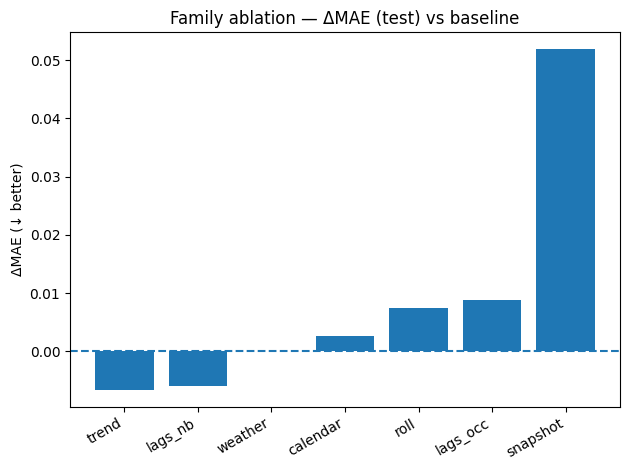

In [18]:
# === 4.3 Plot ΔMAE on test per ablation ===
if 'ablation_df' in globals() and not ablation_df.empty:
    plt.figure()
    ordered = ablation_df.sort_values("Δtest_MAE")["family_removed"]
    plt.bar(ordered, ablation_df.set_index("family_removed").loc[ordered, "Δtest_MAE"])
    plt.axhline(0.0, linestyle='--')
    plt.title("Family ablation — ΔMAE (test) vs baseline")
    plt.ylabel("ΔMAE (↓ better)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

In [19]:
# === 4.4 Keep/Drop suggestion table (thresholds adjustable) ===
if 'ablation_df' in globals() and not ablation_df.empty:
    THR_DELTA = 0.015  # ex. garder la famille si retirer cause +≥1.5% MAE (en absolu, pas relatif)
    base_mae = float(pd.to_numeric(ablation_df["Δtest_MAE"], errors='coerce').fillna(0).abs().min() + 0)  # not used; just placeholder
    suggest = ablation_df.copy()
    suggest["keep?"] = np.where(suggest["Δtest_MAE"] >= THR_DELTA, "KEEP", "CANDIDATE_DROP")
    suggest = suggest[["family_removed","n_features","test_MAE","Δtest_MAE","keep?"]].sort_values(["keep?","Δtest_MAE"], ascending=[True, True])
    display(suggest)

,family_removed,n_features,test_MAE,Δtest_MAE,keep?
4,trend,25,0.996103,-0.006557,CANDIDATE_DROP
1,lags_nb,21,0.996737,-0.005923,CANDIDATE_DROP
6,weather,27,1.002660,0.000000,CANDIDATE_DROP
5,calendar,22,1.005347,0.002686,CANDIDATE_DROP
3,roll,23,1.010034,0.007373,CANDIDATE_DROP
2,lags_occ,21,1.011441,0.008781,CANDIDATE_DROP
0,snapshot,26,1.054536,0.051876,KEEP



## 5. Micro-Level Selection Within Families


In [20]:
# === 5.1 Correlation screen per family ===
from typing import List, Dict
import numpy as np
import pandas as pd

def correlation_screen(df_feat: pd.DataFrame, cols: List[str], thr: float = 0.95) -> List[str]:
    """Keep a subset of cols with pairwise |corr| < thr against already kept ones."""
    cols = [c for c in cols if c in df_feat.columns]
    kept: List[str] = []
    if not cols:
        return kept
    corr = df_feat[cols].corr().abs()
    for c in cols:
        if not kept:
            kept.append(c); continue
        if all(corr.loc[c, k] < thr for k in kept if (c in corr.index) and (k in corr.columns)):
            kept.append(c)
    return kept

# Run correlation screen inside each present family on the VALID set (to avoid leakage)
corr_filtered_families: Dict[str, List[str]] = {}
if 'valid_df' in globals() and not valid_df.empty:
    for fam, fam_cols in FAMILIES.items():
        kept_cols = correlation_screen(valid_df, fam_cols, thr=0.95)
        corr_filtered_families[fam] = kept_cols
corr_filtered_families

{'snapshot': ['capacity_bin', 'occ_ratio_bin'],
 'lags_nb': ['lag_nb_1b', 'lag_nb_24b', 'lag_nb_48b'],
 'lags_occ': ['lag_occ_1b', 'lag_occ_24b', 'lag_occ_48b'],
 'roll': ['roll_nb_12b', 'roll_occ_12b'],
 'trend': ['trend_nb_12b', 'trend_occ_12b'],
 'calendar': ['hour', 'hour_sin', 'hour_cos'],
 'weather': []}

In [21]:
# === 5.2 Permutation importance with real model (LightGBM) ===
import numpy as np
import pandas as pd

def permutation_importance(X: pd.DataFrame, y: np.ndarray, predict_fn, n_repeats: int = 5, rng_seed: int = 123) -> pd.DataFrame:
    rng = np.random.default_rng(rng_seed)
    base_pred = predict_fn(X)
    base_mae = mae(y, base_pred)
    rows = []
    for col in X.columns:
        deltas = []
        for _ in range(n_repeats):
            Xp = X.copy()
            Xp[col] = rng.permutation(Xp[col].values)
            yhat_p = predict_fn(Xp)
            deltas.append(mae(y, yhat_p) - base_mae)
        rows.append({"feature": col, "pi_mean": float(np.mean(deltas)), "pi_std": float(np.std(deltas))})
    out = pd.DataFrame(rows).sort_values("pi_mean", ascending=False).reset_index(drop=True)
    return out

# Ensure we have a trained model from section 3; otherwise train quickly
if 'model' not in globals():
    train_df, valid_df, test_df = make_splits(df, ts_col=TS_COL)
    X_tr = train_df[BASE_FEATURES]; y_tr = train_df[TARGET_COL].to_numpy()
    X_va = valid_df[BASE_FEATURES]; y_va = valid_df[TARGET_COL].to_numpy()
    model = fit_lgbm(X_tr, y_tr, X_valid=X_va, y_valid=y_va)

# Global PI on VALID
Xva_all = valid_df[BASE_FEATURES]
yva_all = valid_df[TARGET_COL].to_numpy()
cap_va  = valid_df[CAPACITY_COL].to_numpy()

predict_fn_global = lambda X: clip_to_capacity(predict_lgbm(model, X), cap_va)
pi_global_df = permutation_importance(Xva_all, yva_all, predict_fn_global, n_repeats=5)
pi_global_df.head(20)

,feature,pi_mean,pi_std
0,lag_nb_1b,3.812068,0.004011
1,roll_nb_12b,1.945592,0.001625
2,occ_ratio_bin,1.782193,0.003590
3,lag_nb_3b,1.130565,0.001840
4,lag_nb_6b,0.485166,0.000402
5,lag_occ_1b,0.090996,0.000498
6,roll_occ_24b,0.041005,0.000194
7,lag_occ_3b,0.035293,0.000139
8,trend_nb_12b,0.032693,0.000114
9,trend_occ_12b,0.029354,0.000070


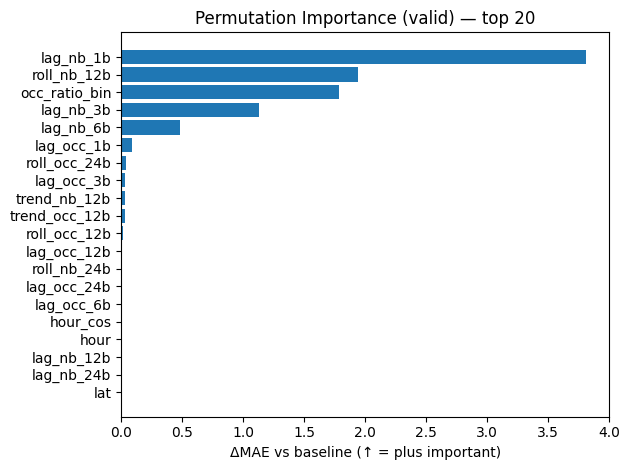

In [22]:
# === Plot top-K permutation importances (global) ===
if 'pi_global_df' in globals() and not pi_global_df.empty:
    K = 20
    topk = pi_global_df.head(K).sort_values("pi_mean")
    plt.figure()
    plt.barh(topk["feature"], topk["pi_mean"])
    plt.title(f"Permutation Importance (valid) — top {K}")
    plt.xlabel("ΔMAE vs baseline (↑ = plus important)")
    plt.tight_layout(); plt.show()

In [24]:
# Utilitaire générique : permutation importance en permutant un sous-ensemble de colonnes,
# mais en prédisant toujours avec le full X (mêmes colonnes qu'au training).
def permutation_importance_on_columns(
    full_X: pd.DataFrame,
    y: np.ndarray,
    cols_to_permute: list[str],
    predict_fn,             # doit accepter full_X et renvoyer yhat
    n_repeats: int = 5,
    rng_seed: int = 123
) -> pd.DataFrame:
    rng = np.random.default_rng(rng_seed)
    base_pred = predict_fn(full_X)
    base_mae = mae(y, base_pred)
    rows = []

    # On mesure l'importance colonne par colonne
    for col in cols_to_permute:
        if col not in full_X.columns:
            continue
        deltas = []
        for _ in range(n_repeats):
            Xp = full_X.copy()
            Xp[col] = rng.permutation(Xp[col].values)
            yhat_p = predict_fn(Xp)
            deltas.append(mae(y, yhat_p) - base_mae)
        rows.append({"feature": col, "pi_mean": float(np.mean(deltas)), "pi_std": float(np.std(deltas))})

    out = pd.DataFrame(rows).sort_values("pi_mean", ascending=False).reset_index(drop=True)
    return out

In [25]:
# predict_fn qui garde la même forme de features que l'entraînement
# (model doit être celui entraîné en 3.3 sur X_tr[BASE_FEATURES])
predict_fn_global = lambda X: clip_to_capacity(predict_lgbm(model, X[BASE_FEATURES]), cap_va)

# PI "globale" (sur toutes les colonnes utilisées à l'entraînement)
pi_global_df = permutation_importance_on_columns(
    full_X=Xva_all,
    y=yva_all,
    cols_to_permute=BASE_FEATURES,
    predict_fn=predict_fn_global,
    n_repeats=5,
    rng_seed=123
)
pi_global_df.head(20)

,feature,pi_mean,pi_std
0,lag_nb_1b,3.812068,0.004011
1,roll_nb_12b,1.945592,0.001625
2,occ_ratio_bin,1.782193,0.003590
3,lag_nb_3b,1.130565,0.001840
4,lag_nb_6b,0.485166,0.000402
5,lag_occ_1b,0.090996,0.000498
6,roll_occ_24b,0.041005,0.000194
7,lag_occ_3b,0.035293,0.000139
8,trend_nb_12b,0.032693,0.000114
9,trend_occ_12b,0.029354,0.000070


In [26]:
# PI par famille (chaque famille = sous-ensemble permuté, mais prédiction sur full_X)
pi_by_family = {}
for fam, fam_cols in corr_filtered_families.items():
    fam_cols = [c for c in fam_cols if c in BASE_FEATURES]  # sécurité
    if not fam_cols:
        continue
    pi_by_family[fam] = permutation_importance_on_columns(
        full_X=Xva_all,
        y=yva_all,
        cols_to_permute=fam_cols,
        predict_fn=predict_fn_global,
        n_repeats=5,
        rng_seed=123
    )

{fam: df.head(5) for fam, df in pi_by_family.items()}

{'snapshot':          feature   pi_mean    pi_std
 0  occ_ratio_bin  1.780103  0.002107,
 'lags_nb':       feature   pi_mean        pi_std
 0   lag_nb_1b  3.810744  3.240020e-03
 1  lag_nb_24b  0.000787  9.597825e-06
 2  lag_nb_48b  0.000004  1.364287e-07,
 'lags_occ':        feature   pi_mean    pi_std
 0   lag_occ_1b  0.091056  0.000286
 1  lag_occ_24b  0.006992  0.000049
 2  lag_occ_48b  0.000101  0.000004,
 'roll':         feature   pi_mean    pi_std
 0   roll_nb_12b  1.944241  0.002207
 1  roll_occ_12b  0.014486  0.000032,
 'trend':          feature   pi_mean   pi_std
 0   trend_nb_12b  0.032719  0.00025
 1  trend_occ_12b  0.029282  0.00012,
 'calendar':     feature   pi_mean    pi_std
 0  hour_cos  0.004819  0.000085
 1      hour  0.001547  0.000027
 2  hour_sin -0.000005  0.000004}

In [27]:
# === 5.3 Greedy backward per family (valid set) ===
from copy import deepcopy

TOL_MAE = 0.002  # tolérance absolue de dégradation MAE valid (à adapter: 0.001–0.003)

def eval_mae_from_features(feats: List[str]) -> float:
    """Fit LGBM on train with 'feats', evaluate MAE on valid (clipped)."""
    X_tr = train_df[feats]; y_tr = train_df[TARGET_COL].to_numpy()
    X_va = valid_df[feats]; y_va = valid_df[TARGET_COL].to_numpy(); cap_va = valid_df[CAPACITY_COL].to_numpy()
    m = fit_lgbm(X_tr, y_tr, X_valid=X_va, y_valid=y_va)
    yhat = clip_to_capacity(predict_lgbm(m, X_va), cap_va)
    return mae(y_va, yhat)

# Base perf with all BASE_FEATURES
train_df, valid_df, test_df = make_splits(df, ts_col=TS_COL)
base_mae_valid = eval_mae_from_features(BASE_FEATURES)

reduced_families: Dict[str, List[str]] = {}
greedy_logs: Dict[str, pd.DataFrame] = {}

for fam, fam_cols in corr_filtered_families.items():
    fam_cols = [c for c in fam_cols if c in BASE_FEATURES]
    if not fam_cols:
        reduced_families[fam] = []
        greedy_logs[fam] = pd.DataFrame()
        continue

    # start from: all BASE_FEATURES; candidates to drop are in fam_cols
    current_feats = BASE_FEATURES.copy()
    current_mae = base_mae_valid
    log_rows = []

    # importance order within family (from PI if available, else arbitrary)
    fam_pi = pi_by_family.get(fam)
    if fam_pi is not None and not fam_pi.empty:
        order_least_to_most = list(fam_pi.sort_values("pi_mean", ascending=True)["feature"])
    else:
        order_least_to_most = fam_cols  # fallback

    for col in order_least_to_most:
        if col not in current_feats:
            continue
        trial_feats = [f for f in current_feats if f != col]
        trial_mae = eval_mae_from_features(trial_feats)
        delta = trial_mae - current_mae  # positive = pire

        log_rows.append({"removed": col, "prev_MAE": current_mae, "trial_MAE": trial_mae, "ΔMAE": delta})

        if delta <= TOL_MAE:
            # accept removal
            current_feats = trial_feats
            current_mae = trial_mae
        else:
            # reject removal (keep the col)
            pass

    reduced_families[fam] = [c for c in BASE_FEATURES if (c in current_feats) and (c in fam_cols)]
    greedy_logs[fam] = pd.DataFrame(log_rows)

# Résumé : nombre de colonnes gardées par famille
{k: len(v) for k, v in reduced_families.items()}

{'snapshot': 1,
 'lags_nb': 2,
 'lags_occ': 1,
 'roll': 1,
 'trend': 0,
 'calendar': 1,
 'weather': 0}

In [28]:
# === Inspect one family's greedy log ===
fam_to_inspect = next((f for f in greedy_logs.keys() if not greedy_logs[f].empty), None)
if fam_to_inspect:
    display(greedy_logs[fam_to_inspect])
else:
    print("No greedy logs to display (families empty or no changes).")

,removed,prev_MAE,trial_MAE,ΔMAE
0,occ_ratio_bin,0.831717,0.872982,0.041265


In [30]:
# === 5.4 Suggested micro-level retained features (robust) ===

# 1) Déterminer quelles familles considérer
families_to_consider = list(FAMILIES.keys())

if 'ablation_df' in globals() and isinstance(ablation_df, pd.DataFrame) and not ablation_df.empty and "family_removed" in ablation_df.columns:
    if "keep?" in ablation_df.columns:
        # masque série alignée à l'index (évite le piège du scalaire "KEEP")
        mask_keep = (ablation_df["keep?"] == "KEEP")
        kept_fams = ablation_df.loc[mask_keep, "family_removed"].dropna().astype(str).tolist()
        if kept_fams:
            families_to_consider = kept_fams
    # sinon: pas de colonne "keep?" -> on garde toutes les familles

# 2) Agréger les features retenues par famille
SUGGESTED_FEATURES = []
for fam in families_to_consider:
    # prioriser le résultat du greedy (reduced_families), sinon fallback sur la famille brute
    cols = None
    if 'reduced_families' in globals() and isinstance(reduced_families, dict):
        cols = reduced_families.get(fam)
    if not cols:
        cols = FAMILIES.get(fam, [])
    SUGGESTED_FEATURES.extend(cols)

# 3) Dédupliquer en conservant l'ordre d'apparition dans BASE_FEATURES
if 'BASE_FEATURES' in globals():
    order = {f: i for i, f in enumerate(BASE_FEATURES)}
    SUGGESTED_FEATURES = sorted(set(SUGGESTED_FEATURES), key=lambda x: order.get(x, 10**9))
else:
    # fallback si BASE_FEATURES non défini
    seen = set()
    SUGGESTED_FEATURES = [c for c in SUGGESTED_FEATURES if not (c in seen or seen.add(c))]

print("Suggested micro-level features count:", len(SUGGESTED_FEATURES))
SUGGESTED_FEATURES[:30]

Suggested micro-level features count: 8


['occ_ratio_bin',
 'lag_nb_1b',
 'lag_nb_24b',
 'lag_occ_1b',
 'roll_nb_12b',
 'trend_nb_12b',
 'trend_occ_12b',
 'hour']

In [31]:
# === 5.5 Final check with SUGGESTED_FEATURES ===
if SUGGESTED_FEATURES:
    # Train
    X_tr = train_df[SUGGESTED_FEATURES]; y_tr = train_df[TARGET_COL].to_numpy()
    X_va = valid_df[SUGGESTED_FEATURES]; y_va = valid_df[TARGET_COL].to_numpy(); cap_va = valid_df[CAPACITY_COL].to_numpy()
    X_te = test_df[SUGGESTED_FEATURES];  y_te = test_df[TARGET_COL].to_numpy();  cap_te = test_df[CAPACITY_COL].to_numpy()

    model_red = fit_lgbm(X_tr, y_tr, X_valid=X_va, y_valid=y_va)

    yhat_va = clip_to_capacity(predict_lgbm(model_red, X_va), cap_va)
    yhat_te = clip_to_capacity(predict_lgbm(model_red, X_te), cap_te)

    reduced_metrics = {
        "valid": {"MAE": mae(y_va, yhat_va), "WAPE": wape(y_va, yhat_va), "pct_within_2": pct_within_abs(y_va, yhat_va)},
        "test":  {"MAE": mae(y_te, yhat_te), "WAPE": wape(y_te, yhat_te), "pct_within_2": pct_within_abs(y_te, yhat_te)},
        "n_features": len(SUGGESTED_FEATURES)
    }
    reduced_metrics
else:
    print("No SUGGESTED_FEATURES — adjust thresholds or check earlier steps.")

In [32]:
# === 5.6 Export ordered list for manifest ===
ORDERED_FINAL = SUGGESTED_FEATURES.copy()
print("ORDERED_FINAL (paste into section 7 manifest):")
ORDERED_FINAL

ORDERED_FINAL (paste into section 7 manifest):


['occ_ratio_bin',
 'lag_nb_1b',
 'lag_nb_24b',
 'lag_occ_1b',
 'roll_nb_12b',
 'trend_nb_12b',
 'trend_occ_12b',
 'hour']


## 6. Stability Analysis


In [34]:
def weekly_slices(df: pd.DataFrame, ts_col: str = 'ts') -> dict[str, pd.DataFrame]:
    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col], utc=True, errors='coerce')
    iso = d[ts_col].dt.isocalendar()  # year, week, day — gère les datetimes tz-aware
    d['_week_label'] = iso['year'].astype(str) + "-W" + iso['week'].astype(str).str.zfill(2)
    out = {wk: g.drop(columns='_week_label') for wk, g in d.groupby('_week_label', sort=True)}
    return out

# usage
if 'valid_df' in globals() and not valid_df.empty:
    weeks = weekly_slices(valid_df, ts_col=TS_COL)
    list(weeks.keys())[:5]


## 7. Final Selection & Manifest


In [37]:
# === 7. Final Selection & Manifest (robuste sous Windows) ===
from pathlib import Path
import json
import os

# 1) Choisis les features finales
#    - si FINAL_FEATURES est vide, on prend SUGGESTED_FEATURES (sinon BASE_FEATURES en dernier recours)
if 'FINAL_FEATURES' not in globals() or not FINAL_FEATURES:
    if 'SUGGESTED_FEATURES' in globals() and SUGGESTED_FEATURES:
        FINAL_FEATURES = SUGGESTED_FEATURES
    else:
        FINAL_FEATURES = BASE_FEATURES  # fallback

# 2) Types
FEATURE_TYPES = {f: "float" for f in FINAL_FEATURES}
FEATURE_TYPES.update({"station_id": "int64", "capacity_bin": "float"})

# 3) Manifeste
MANIFEST = {
    "version": "1.0",
    "target": "y",
    "features": FINAL_FEATURES,
    "feature_types": FEATURE_TYPES,
    "station_key": "station_id",
    "timestamp_key": TS_COL,
    "capacity_key": "capacity_bin",
    "notes": "Feature reduction manifest generated from the study notebook."
}

# 4) Chemin de sortie local (création auto du dossier)
OUTPUT_DIR = Path("./artifacts")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
manifest_path = OUTPUT_DIR / "feature_manifest.json"

manifest_path.write_text(json.dumps(MANIFEST, indent=2), encoding='utf-8')
print(f"[OK] Manifest written to: {manifest_path.resolve()}")
print(f"n_features = {len(FINAL_FEATURES)}")
manifest_path

[OK] Manifest written to: C:\Users\Administrator\velib\artifacts\feature_manifest.json
n_features = 8


WindowsPath('artifacts/feature_manifest.json')


## 8. Appendix
- Data dictionary
- Station coverage
- Extra plots
